## Packages

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import os
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from sunpy.timeseries.sources.goes import XRSTimeSeries
import astropy.units as u
from sunkit_instruments.goes_xrs import calculate_temperature_em
import matplotlib.pyplot as plt
import numpy as np
from sunpy.data import manager
import netCDF4 as nc
import os
import pandas as pd
from datetime import datetime, timedelta
import copy
from matplotlib import colormaps
list(colormaps)
#from colorspacious import cspace_converter
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterMathtext
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob

## Funciones gráficas

In [2]:
def plot_fai_flare_dualbar(df_fai_assoc, df_anticipation_time, n_days, window_minutes,
                          column_assoc="Associated_Flare", fai_column="FAIalerts_WPeak"):
    """
    Genera un gráfico con dos barras verticales al 100%:
    - Una para Flares (con/sin FAI)
    - Una para FAIs (asociados/no asociados)
    
    Parameters
    ----------
    df_fai_assoc : DataFrame
        DataFrame con FAIs (debe incluir columna 'Associated_Flare')
    df_anticipation_time : DataFrame
        DataFrame con flares (debe incluir columna FAIalerts_W)
    n_days : int
        Número de días analizados
    window_minutes : int
        Ventana temporal usada para definir la asociación
    column_assoc : str
        Columna booleana en df_fai_assoc que indica si el FAI está asociado a un flare
    fai_column : str
        Columna en df_anticipation_time que indica si el flare tiene FAI
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import os

    # --- Preparar datos de FAIs ---
    fai_assoc_true = df_fai_assoc[column_assoc].sum()
    fai_assoc_false = (~df_fai_assoc[column_assoc]).sum()
    total_fai = fai_assoc_true + fai_assoc_false
    pct_fai_assoc = fai_assoc_true / total_fai * 100
    pct_fai_notassoc = fai_assoc_false / total_fai * 100

    # --- Preparar datos de Flares ---
    if df_anticipation_time[fai_column].dtype in ['int64', 'float64']:
        df_anticipation_time['FAI_bool'] = df_anticipation_time[fai_column] > 0
    else:
        df_anticipation_time['FAI_bool'] = df_anticipation_time[fai_column].astype(bool)

    flare_with_fai = df_anticipation_time['FAI_bool'].sum()
    flare_without_fai = (~df_anticipation_time['FAI_bool']).sum()
    total_flare = flare_with_fai + flare_without_fai
    pct_flare_with = flare_with_fai / total_flare * 100
    pct_flare_without = flare_without_fai / total_flare * 100

    # --- Gráfico con espacio para el recuadro de totales ---
    fig, ax = plt.subplots(figsize=(6, 5.5))

    bars = ["Flares", "FAIs"]
    
    # Parte inferior (asociados)
    ax.bar(bars, [pct_flare_with, pct_fai_assoc],
           color='#6BCB77', label='Associated', alpha=0.9, edgecolor='black')

    # Parte superior (no asociados)
    ax.bar(bars, [pct_flare_without, pct_fai_notassoc],
           bottom=[pct_flare_with, pct_fai_assoc],
           color='#FF6B6B', label='Not Associated', alpha=0.9, edgecolor='black')

    # Etiquetas de porcentaje dentro de cada parte
    for i, (with_pct, without_pct) in enumerate(zip([pct_flare_with, pct_fai_assoc],
                                                    [pct_flare_without, pct_fai_notassoc])):
        # Etiqueta para la parte inferior (asociados)
        if with_pct > 5:
            ax.text(i, with_pct / 2, f"{with_pct:.1f}%",
                    ha='center', va='center', fontsize=10, color='black', fontweight='bold')
        
        # Etiqueta para la parte superior (no asociados)
        if without_pct > 5:
            ax.text(i, with_pct + without_pct / 2, f"{without_pct:.1f}%",
                    ha='center', va='center', fontsize=10, color='black', fontweight='bold')

    # Ejes y formato
    ax.set_ylim(0, 101)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_title(f"FAI–Flare Association Overview\n({n_days} days, Window = {window_minutes} min)",
                pad=20, fontsize=13, fontweight='bold')

    # Leyenda
    legend = ax.legend(title="Association", loc='center left', bbox_to_anchor=(1.02, 0.5),
                      frameon=True, fontsize=11, title_fontsize=12,
                      framealpha=0.9, edgecolor='gray')

    # Recuadro con los totales arriba de la leyenda
    total_text = f"Total Samples:\nFlares: {total_flare}\nFAIs: {total_fai}"
    
    # Crear el recuadro de totales
    props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8, edgecolor='black')
    ax.text(1.12, 0.85, total_text, transform=ax.transAxes, fontsize=11,
            fontweight='bold', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.5)

    # Recuadro 2: Parámetros FAI (debajo de la leyenda)
    params_text = f"Window:{fai_column}\nMethod:{method}\nFAI Parameters:\nT: {fai_temp_range[0]}-{fai_temp_range[1]} MK\nEM > {fai_em_threshold}\nDuration: {FAI_duration} {duration}"
    
    ax.text(1.12, 0.25, params_text, transform=ax.transAxes, fontsize=9,
            fontweight='normal', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.3)


    # Estilo general
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    # Ajustar layout para dar espacio al recuadro
    plt.tight_layout(rect=[0, 0, 0.82, 1])

    # Guardar figura
    output_name = f"{method}{n_days}d_FAI_Flare_DualBar_W{window_minutes}min{fai_column}_dur{duration}_{FAI_duration}_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=False) # transparent = True -> sin fondo, 
                                                                             #  transparent = False -> fondo blanco
    plt.show()

    print(f"✅ Gráfico guardado en: {output_path}")
    print("\n--- Resumen ---")
    print(f"Total Flares: {total_flare} → {pct_flare_with:.1f}% con FAI, {pct_flare_without:.1f}% sin FAI")
    print(f"Total FAIs: {total_fai} → {pct_fai_assoc:.1f}% asociados, {pct_fai_notassoc:.1f}% no asociados")

def plot_fai_flare_triplebar(df_fai_assoc, df_anticipation_time, n_days, window_minutes,
                            column_assoc="Associated_Flare", fai_column="FAIalerts_W"):
    """
    Genera un gráfico con dos barras verticales al 100%:
    - Una para Flares (discriminado por ventanas temporales)
    - Una para FAIs (asociados/no asociados)
    
    Parameters
    ----------
    df_fai_assoc : DataFrame
        DataFrame con FAIs (debe incluir columna 'Associated_Flare')
    df_anticipation_time : DataFrame
        DataFrame con flares (debe incluir columnas FAIalerts_WStart, FAIalerts_StartPeak, FAIalerts_PeakEnd)
    n_days : int
        Número de días analizados
    window_minutes : int
        Ventana temporal usada para definir la asociación
    column_assoc : str
        Columna booleana en df_fai_assoc que indica si el FAI está asociado a un flare
    fai_column : str
        Columna base en df_anticipation_time para las estadísticas
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import os
    import numpy as np

    # --- Preparar datos de FAIs ---
    fai_assoc_true = df_fai_assoc[column_assoc].sum()
    fai_assoc_false = (~df_fai_assoc[column_assoc]).sum()
    total_fai = fai_assoc_true + fai_assoc_false
    pct_fai_assoc = fai_assoc_true / total_fai * 100
    pct_fai_notassoc = fai_assoc_false / total_fai * 100

    # --- Preparar datos de Flares por ventanas temporales ---
    # Flares con FAI antes del Start
    flares_before_start = (df_anticipation_time["FAIalerts_WStart"] > 0).sum()
    flares_only_during_start_peak = ((df_anticipation_time["FAIalerts_WStart"] == 0) & 
                                   (df_anticipation_time["FAIalerts_StartPeak"] > 0)).sum()
    flares_only_during_peak_end = ((df_anticipation_time["FAIalerts_WStart"] == 0) & 
                                 (df_anticipation_time["FAIalerts_StartPeak"] == 0) & 
                                 (df_anticipation_time["FAIalerts_PeakEnd"] > 0)).sum()
    flares_without_fai = ((df_anticipation_time["FAIalerts_WStart"] == 0) & 
                        (df_anticipation_time["FAIalerts_StartPeak"] == 0) & 
                        (df_anticipation_time["FAIalerts_PeakEnd"] == 0)).sum()

    total_flare = len(df_anticipation_time)
    
    # Verificar que la suma sea correcta
    total_check = (flares_before_start + flares_only_during_start_peak + 
                  flares_only_during_peak_end + flares_without_fai)
    
    if total_check != total_flare:
        print(f"⚠️ Advertencia: Suma de categorías ({total_check}) no coincide con total de flares ({total_flare})")
        # Ajustar por redondeo
        flares_without_fai = total_flare - (flares_before_start + flares_only_during_start_peak + flares_only_during_peak_end)

    # Calcular porcentajes
    pct_before_start = flares_before_start / total_flare * 100
    pct_during_start_peak = flares_only_during_start_peak / total_flare * 100
    pct_during_peak_end = flares_only_during_peak_end / total_flare * 100
    pct_without_fai = flares_without_fai / total_flare * 100

    # --- Gráfico con espacio para el recuadro de totales ---
    fig, ax = plt.subplots(figsize=(7, 6))

    bars = ["Flares", "FAIs"]
    
    # Colores para las diferentes categorías de flares
    colors_flares = ['#2E8B57', '#6BCB77', '#A8E6A3', '#FF6B6B']  # Verde oscuro a claro, luego rojo
    
    # Barra de FLARES (4 segmentos)
    flare_segments = [pct_before_start, pct_during_start_peak, pct_during_peak_end, pct_without_fai]
    flare_labels = ['Before Start', 'Start to Peak', 'Peak to End', 'No FAI']
    
    bottom = 0
    for i, (pct, color, label) in enumerate(zip(flare_segments, colors_flares, flare_labels)):
        ax.bar(bars[0], pct, bottom=bottom, color=color, label=label, alpha=0.9, edgecolor='black')
        # Etiqueta dentro de la barra si el segmento es suficientemente grande
        if pct > 3:
            ax.text(0, bottom + pct/2, f"{pct:.1f}%", 
                    ha='center', va='center', fontsize=9, color='black', fontweight='bold')
        bottom += pct

    # Barra de FAIs (2 segmentos - misma lógica original)
    ax.bar(bars[1], pct_fai_assoc, color='#6BCB77', alpha=0.9, edgecolor='black')
    ax.bar(bars[1], pct_fai_notassoc, bottom=pct_fai_assoc, color='#FF6B6B', alpha=0.9, edgecolor='black')
    
    # Etiquetas para barra de FAIs
    if pct_fai_assoc > 5:
        ax.text(1, pct_fai_assoc / 2, f"{pct_fai_assoc:.1f}%",
                ha='center', va='center', fontsize=10, color='black', fontweight='bold')
    if pct_fai_notassoc > 5:
        ax.text(1, pct_fai_assoc + pct_fai_notassoc / 2, f"{pct_fai_notassoc:.1f}%",
                ha='center', va='center', fontsize=10, color='black', fontweight='bold')

    # Ejes y formato
    ax.set_ylim(0, 101)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_title(f"FAI–Flare Temporal Distribution\n({n_days} days, Window = {window_minutes} min)",
                pad=20, fontsize=13, fontweight='bold')

    # Leyenda para flares (más detallada)
    legend_flares = ax.legend(title="Flare Categories", loc='center left', bbox_to_anchor=(1.02, 0.6),
                             frameon=True, fontsize=10, title_fontsize=11,
                             framealpha=0.9, edgecolor='gray')

    # Leyenda simple para FAIs
    from matplotlib.patches import Patch
    fai_legend_elements = [
        Patch(facecolor='#6BCB77', label='FAI Associated'),
        Patch(facecolor='#FF6B6B', label='FAI Not Associated')
    ]
    legend_fais = ax.legend(handles=fai_legend_elements, title="FAI Status", 
                           loc='center left', bbox_to_anchor=(1.02, 0.4),
                           frameon=True, fontsize=10, title_fontsize=11,
                           framealpha=0.9, edgecolor='gray')
    
    # Añadir ambas leyendas al gráfico
    ax.add_artist(legend_flares)

    # Recuadro con los totales
    total_text = f"Total Samples:\nFlares: {total_flare}\nFAIs: {total_fai}"
    
    props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8, edgecolor='black')
    ax.text(1.12, 0.9, total_text, transform=ax.transAxes, fontsize=11,
            fontweight='bold', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.5)

    # Recuadro 2: Parámetros FAI
    params_text = f"Window: {fai_column}\nMethod: {method}\nFAI Parameters:\nT: {fai_temp_range[0]}-{fai_temp_range[1]} MK\nEM > {fai_em_threshold}\nDuration: {FAI_duration} {duration}"
    
    ax.text(1.12, 0.25, params_text, transform=ax.transAxes, fontsize=9,
            fontweight='normal', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.3)

    # Estilo general
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    # Ajustar layout para dar espacio a las leyendas
    plt.tight_layout(rect=[0, 0, 0.75, 1])

    # Guardar figura
    output_name = f"{method}{n_days}d_FAI_Flare_TripleBar_W{window_minutes}min{fai_column}_dur{duration}_{FAI_duration}_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=False)
    plt.show()

    print(f"✅ Gráfico guardado en: {output_path}")
    print("\n--- Resumen Detallado ---")
    print(f"FLARES (Total: {total_flare}):")
    print(f"  • Con FAI ANTES del Start:    {flares_before_start} ({pct_before_start:.1f}%)")
    print(f"  • Con FAI solo ENTRE Start-Peak: {flares_only_during_start_peak} ({pct_during_start_peak:.1f}%)")
    print(f"  • Con FAI solo ENTRE Peak-End:   {flares_only_during_peak_end} ({pct_during_peak_end:.1f}%)")
    print(f"  • SIN FAI en ninguna ventana: {flares_without_fai} ({pct_without_fai:.1f}%)")
    print(f"FAIs (Total: {total_fai}):")
    print(f"  • Asociados a flares:    {fai_assoc_true} ({pct_fai_assoc:.1f}%)")
    print(f"  • No asociados a flares: {fai_assoc_false} ({pct_fai_notassoc:.1f}%)")

# Ejemplo de uso:
# plot_fai_flare_triplebar(df_fai_assoc, df_anticipation_time, n_days, window_minutes,
#                         column_assoc="Associated_Flare", fai_column="FAIalerts_W")

def plot_fai_flare_triplebar2(df_fai_assoc, df_anticipation_time, n_days, window_minutes,
                            column_assoc="Associated_Flare", fai_column="FAIalerts_W"):
    """
    Genera un gráfico con dos barras verticales al 100%:
    - Una para Flares (discriminado por ventanas temporales según fai_column)
    - Una para FAIs (asociados/no asociados)
    
    Parameters
    ----------
    df_fai_assoc : DataFrame
        DataFrame con FAIs (debe incluir columna 'Associated_Flare')
    df_anticipation_time : DataFrame
        DataFrame con flares (debe incluir columnas FAIalerts_WStart, FAIalerts_StartPeak, FAIalerts_PeakEnd)
    n_days : int
        Número de días analizados
    window_minutes : int
        Ventana temporal usada para definir la asociación
    column_assoc : str
        Columna booleana en df_fai_assoc que indica si el FAI está asociado a un flare
    fai_column : str
        Columna en df_anticipation_time que indica qué ventana usar para determinar flares con FAI
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import os
    import numpy as np

    # --- Preparar datos de FAIs ---
    fai_assoc_true = df_fai_assoc[column_assoc].sum()
    fai_assoc_false = (~df_fai_assoc[column_assoc]).sum()
    total_fai = fai_assoc_true + fai_assoc_false
    pct_fai_assoc = fai_assoc_true / total_fai * 100
    pct_fai_notassoc = fai_assoc_false / total_fai * 100

    # --- Preparar datos de Flares usando fai_column ---
    if df_anticipation_time[fai_column].dtype in ['int64', 'float64']:
        df_anticipation_time['FAI_bool'] = df_anticipation_time[fai_column] > 0
    else:
        df_anticipation_time['FAI_bool'] = df_anticipation_time[fai_column].astype(bool)

    flare_with_fai = df_anticipation_time['FAI_bool'].sum()
    flare_without_fai = (~df_anticipation_time['FAI_bool']).sum()
    total_flare = flare_with_fai + flare_without_fai
    pct_flare_with = flare_with_fai / total_flare * 100
    pct_flare_without = flare_without_fai / total_flare * 100

    # --- Determinar qué ventanas mostrar según fai_column ---
    if fai_column == "FAIalerts_W":
        # Ventana completa: mostrar todas las categorías
        flares_before_start = (df_anticipation_time["FAIalerts_WStart"] > 0).sum()
        flares_only_during_start_peak = ((df_anticipation_time["FAIalerts_WStart"] == 0) & 
                                       (df_anticipation_time["FAIalerts_StartPeak"] > 0)).sum()
        flares_only_during_peak_end = ((df_anticipation_time["FAIalerts_WStart"] == 0) & 
                                     (df_anticipation_time["FAIalerts_StartPeak"] == 0) & 
                                     (df_anticipation_time["FAIalerts_PeakEnd"] > 0)).sum()
        flares_without_fai = ((df_anticipation_time["FAIalerts_WStart"] == 0) & 
                            (df_anticipation_time["FAIalerts_StartPeak"] == 0) & 
                            (df_anticipation_time["FAIalerts_PeakEnd"] == 0)).sum()
        
        flare_segments = [flares_before_start, flares_only_during_start_peak, flares_only_during_peak_end, flares_without_fai]
        flare_labels = ['Before Start', 'Start to Peak', 'Peak to End', 'No FAI']
        colors_flares = ['#2E8B57', '#6BCB77', '#A8E6A3', '#FF6B6B']
        
    elif fai_column == "FAIalerts_WStart":
        # Solo FAIs antes del Start
        flares_with_fai_before_start = (df_anticipation_time["FAIalerts_WStart"] > 0).sum()
        flares_without_fai_before_start = total_flare - flares_with_fai_before_start
        
        flare_segments = [flares_with_fai_before_start, flares_without_fai_before_start]
        flare_labels = ['FAI Before Start', 'No FAI Before Start']
        colors_flares = ['#2E8B57', '#FF6B6B']
        
    elif fai_column == "FAIalerts_WPeak":
        # FAIs antes del Peak (incluye Before Start + Start to Peak)
        flares_before_start = (df_anticipation_time["FAIalerts_WStart"] > 0).sum()
        flares_only_during_start_peak = ((df_anticipation_time["FAIalerts_WStart"] == 0) & 
                                       (df_anticipation_time["FAIalerts_StartPeak"] > 0)).sum()
        flares_without_fai_before_peak = total_flare - (flares_before_start + flares_only_during_start_peak)
        
        flare_segments = [flares_before_start, flares_only_during_start_peak, flares_without_fai_before_peak]
        flare_labels = ['Before Start', 'Start to Peak', 'No FAI Before Peak']
        colors_flares = ['#2E8B57', '#6BCB77', '#FF6B6B']
        
    elif fai_column == "FAIalerts_StartPeak":
        # Solo FAIs entre Start y Peak
        flares_with_fai_start_peak = (df_anticipation_time["FAIalerts_StartPeak"] > 0).sum()
        flares_without_fai_start_peak = total_flare - flares_with_fai_start_peak
        
        flare_segments = [flares_with_fai_start_peak, flares_without_fai_start_peak]
        flare_labels = ['FAI Start-Peak', 'No FAI Start-Peak']
        colors_flares = ['#A8E6A3', '#FF6B6B']
        
    elif fai_column == "FAIalerts_PeakEnd":
        # Solo FAIs entre Peak y End
        flares_with_fai_peak_end = (df_anticipation_time["FAIalerts_PeakEnd"] > 0).sum()
        flares_without_fai_peak_end = total_flare - flares_with_fai_peak_end
        
        flare_segments = [flares_with_fai_peak_end, flares_without_fai_peak_end]
        flare_labels = ['FAI Peak-End', 'No FAI Peak-End']
        colors_flares = ['#A8E6A3', '#FF6B6B']
        
    else:
        # Por defecto, usar ventana completa
        flares_with_fai = (df_anticipation_time[fai_column] > 0).sum()
        flares_without_fai = total_flare - flares_with_fai
        
        flare_segments = [flares_with_fai, flares_without_fai]
        flare_labels = [f'With {fai_column}', f'Without {fai_column}']
        colors_flares = ['#6BCB77', '#FF6B6B']

    # Calcular porcentajes
    pct_flare_segments = [segment / total_flare * 100 for segment in flare_segments]

    # --- Gráfico con espacio para el recuadro de totales ---
    fig, ax = plt.subplots(figsize=(7, 6))

    bars = ["Flares", "FAIs"]
    
    # Barra de FLARES (segmentos variables según fai_column)
    bottom = 0
    for i, (pct, color, label) in enumerate(zip(pct_flare_segments, colors_flares, flare_labels)):
        ax.bar(bars[0], pct, bottom=bottom, color=color, label=label, alpha=0.9, edgecolor='black')
        # Etiqueta dentro de la barra si el segmento es suficientemente grande
        if pct > 3:
            ax.text(0, bottom + pct/2, f"{pct:.1f}%", 
                    ha='center', va='center', fontsize=9, color='black', fontweight='bold')
        bottom += pct

    # Barra de FAIs (2 segmentos - misma lógica original)
    ax.bar(bars[1], pct_fai_assoc, color='#6BCB77', alpha=0.9, edgecolor='black')
    ax.bar(bars[1], pct_fai_notassoc, bottom=pct_fai_assoc, color='#FF6B6B', alpha=0.9, edgecolor='black')
    
    # Etiquetas para barra de FAIs
    if pct_fai_assoc > 5:
        ax.text(1, pct_fai_assoc / 2, f"{pct_fai_assoc:.1f}%",
                ha='center', va='center', fontsize=10, color='black', fontweight='bold')
    if pct_fai_notassoc > 5:
        ax.text(1, pct_fai_assoc + pct_fai_notassoc / 2, f"{pct_fai_notassoc:.1f}%",
                ha='center', va='center', fontsize=10, color='black', fontweight='bold')

    # Ejes y formato
    ax.set_ylim(0, 101)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_title(f"FAI–Flare Association: {fai_column}\n({n_days} days, Window = {window_minutes} min)",
                pad=20, fontsize=13, fontweight='bold')

    # Leyenda para flares
    legend_flares = ax.legend(title=f"Flare Categories\n({fai_column})", 
                             loc='center left', bbox_to_anchor=(1.02, 0.6),
                             frameon=True, fontsize=10, title_fontsize=11,
                             framealpha=0.9, edgecolor='gray')

    # Leyenda simple para FAIs
    from matplotlib.patches import Patch
    fai_legend_elements = [
        Patch(facecolor='#6BCB77', label='FAI Associated'),
        Patch(facecolor='#FF6B6B', label='FAI Not Associated')
    ]
    legend_fais = ax.legend(handles=fai_legend_elements, title="FAI Status", 
                           loc='center left', bbox_to_anchor=(1.02, 0.35),
                           frameon=True, fontsize=10, title_fontsize=11,
                           framealpha=0.9, edgecolor='gray')
    
    # Añadir ambas leyendas al gráfico
    ax.add_artist(legend_flares)

    # Recuadro con los totales
    total_text = f"Total Samples:\nFlares: {total_flare}\nFAIs: {total_fai}"
    
    props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8, edgecolor='black')
    ax.text(1.12, 0.9, total_text, transform=ax.transAxes, fontsize=11,
            fontweight='bold', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.5)

    # Recuadro 2: Parámetros FAI
    params_text = f"Window: {fai_column}\nMethod: {method}\nFAI Parameters:\nT: {fai_temp_range[0]}-{fai_temp_range[1]} MK\nEM > {fai_em_threshold}\nDuration: {FAI_duration} {duration}"
    
    ax.text(1.12, 0.25, params_text, transform=ax.transAxes, fontsize=9,
            fontweight='normal', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.3)

    # Estilo general
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    # Ajustar layout para dar espacio a las leyendas
    plt.tight_layout(rect=[0, 0, 0.75, 1])

    # Guardar figura
    output_name = f"{method}{n_days}d_FAI_Flare_TripleBar_{fai_column}_W{window_minutes}min_dur{duration}_{FAI_duration}_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=False)
    plt.show()

    print(f"✅ Gráfico guardado en: {output_path}")
    print(f"\n--- Resumen para {fai_column} ---")
    print(f"FLARES (Total: {total_flare}):")
    for label, count, pct in zip(flare_labels, flare_segments, pct_flare_segments):
        print(f"  • {label}: {count} ({pct:.1f}%)")
    print(f"FAIs (Total: {total_fai}):")
    print(f"  • Asociados a flares:    {fai_assoc_true} ({pct_fai_assoc:.1f}%)")
    print(f"  • No asociados a flares: {fai_assoc_false} ({pct_fai_notassoc:.1f}%)")




    
##

## Parameters

In [3]:
n=185
# nuevo número de días
new_n = 148
fecha_actual = "2025-11-11"

window_minutes=30
fai_temp_range = (7, 14)
fai_em_threshold = 0.005
date_column = "date"
duration = True
FAI_duration = 3
filter_flare_coincidence = True
method = "filtered" # "all", "true" o "filtered"

## Carpeta para gráficas

In [4]:
analysis_dir = os.path.join(f"Analysis_FAI")
# Crear carpeta de análisis (si no existe) y mostrar mensaje
if os.path.exists(analysis_dir ):
    print(f"⚠️ La carpeta de análisis ya existía: {analysis_dir }")
else:
    os.makedirs(analysis_dir , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {analysis_dir}")

# Crear subcarpeta para guardar resultados de análisis
analysis_esp = os.path.join(analysis_dir, f"Analysis_FAI_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min")
# Crear carpeta de análisis (si no existe) y mostrar mensaje
if os.path.exists(analysis_esp ):
    print(f"⚠️ La carpeta de análisis ya existía: {analysis_esp }")
else:
    os.makedirs(analysis_esp , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {analysis_esp}")

folder = f"Graphics_{method}_W{window_minutes}min"

# Crear subcarpeta para guardar resultados de análisis
graphics_dir = os.path.join(analysis_esp, folder)
# Crear subcarpeta para guardar resultados de análisis (si no existe) y mostrar mensaje
if os.path.exists(graphics_dir):
    print(f"⚠️ La carpeta de análisis ya existía: {graphics_dir}")
else:
    os.makedirs(graphics_dir , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {graphics_dir}")




⚠️ La carpeta de análisis ya existía: Analysis_FAI
⚠️ La carpeta de análisis ya existía: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min
⚠️ La carpeta de análisis ya existía: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min


## Valid Data 

In [5]:
output_dir = f"Data_for_{n}_days"

# Path of cleaned data in csv
csv_path_full_valid = f"{output_dir}/df_full_{new_n}_valid.csv"
# Path of valid flares: 
csv_path_flares = f"{output_dir}/df_flares_{new_n}_valid.csv"
# Path of df_full
csv_path_full = f"{output_dir}/all_df_full_{n}.csv"

# Verificar existencia de archivos y avisar
if not os.path.exists(csv_path_full_valid):
    print(f"⚠️ No se encontró el archivo GOES: {csv_path_full_valid}")
else:
    print(f"✅ Archivo GOES encontrado: {csv_path_full_valid}")

if not os.path.exists(csv_path_flares):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_flares}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_flares}")

if not os.path.exists(csv_path_full):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_full}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_full}")

df_full_valid = pd.read_csv(csv_path_full_valid)
df_flares_valid = pd.read_csv(csv_path_flares)
df_full = pd.read_csv(csv_path_full)

✅ Archivo GOES encontrado: Data_for_185_days/df_full_148_valid.csv
✅ Archivo de flares encontrado: Data_for_185_days/df_flares_148_valid.csv
✅ Archivo de flares encontrado: Data_for_185_days/all_df_full_185.csv


## Data_method

In [6]:
# Path of anticipation_time
csv_path_anticipation_time = f"{analysis_esp}/df_anticipation_time_{method}_(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of fai_all
csv_path_fai_all = f"{analysis_esp}/df_fai_all_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of fai_selected
csv_path_fai_selected = f"{analysis_esp}/df_fai_{method}_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of df_fai_assoc
csv_path_fai_assoc = f"{analysis_esp}/df_fai_assoc2_{method}_(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"

if not os.path.exists(csv_path_anticipation_time):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_anticipation_time}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_anticipation_time}")
if not os.path.exists(csv_path_fai_all):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_fai_all}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_fai_all}")
if not os.path.exists(csv_path_fai_selected):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_fai_selected}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_fai_selected}")
if not os.path.exists(csv_path_fai_assoc):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_fai_assoc}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_fai_assoc}")


df_anticipation_time = pd.read_csv(csv_path_anticipation_time)
df_fai_all = pd.read_csv(csv_path_fai_all)
df_fai_selected = pd.read_csv(csv_path_fai_selected)
df_fai_assoc = pd.read_csv(csv_path_fai_assoc)



✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_anticipation_time_filtered_(W_30)_T7-14_EM0.005_dur3min.csv
✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_fai_all_T7-14_EM0.005_dur3min.csv
✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_fai_filtered_T7-14_EM0.005_dur3min.csv
✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_fai_assoc2_filtered_(W_30)_T7-14_EM0.005_dur3min.csv


## Info dfs

In [7]:
df_full_valid["date"] = pd.to_datetime(df_full_valid["date"])
df_flares_valid["StartTime"] = pd.to_datetime(df_flares_valid["StartTime"])
df_flares_valid["PeakTime"]  = pd.to_datetime(df_flares_valid["PeakTime"])
df_flares_valid["EndTime"]   = pd.to_datetime(df_flares_valid["EndTime"])
df_anticipation_time["StartTime"] = pd.to_datetime(df_anticipation_time["StartTime"])
df_anticipation_time["PeakTime"]  = pd.to_datetime(df_anticipation_time["PeakTime"])
df_anticipation_time["EndTime"]   = pd.to_datetime(df_anticipation_time["EndTime"])
df_fai_selected["date"] = pd.to_datetime(df_fai_selected["date"])

In [8]:
df_flares_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Flare_ID     1433 non-null   object        
 1   StartTime    1433 non-null   datetime64[ns]
 2   PeakTime     1433 non-null   datetime64[ns]
 3   EndTime      1433 non-null   datetime64[ns]
 4   Class        1433 non-null   object        
 5   ClassLetter  1433 non-null   object        
 6   ClassNumber  1433 non-null   float64       
 7   ClassGroup   1433 non-null   object        
 8   Observatory  1433 non-null   object        
 9   StartPeak    1433 non-null   float64       
 10  PeakEnd      1433 non-null   float64       
 11  StartEnd     1433 non-null   float64       
 12  day          1433 non-null   object        
dtypes: datetime64[ns](3), float64(4), object(6)
memory usage: 145.7+ KB


In [9]:
df_anticipation_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Flare_ID                    1433 non-null   object        
 1   StartTime                   1433 non-null   datetime64[ns]
 2   PeakTime                    1433 non-null   datetime64[ns]
 3   EndTime                     1433 non-null   datetime64[ns]
 4   Class                       1433 non-null   object        
 5   ClassLetter                 1433 non-null   object        
 6   ClassNumber                 1433 non-null   float64       
 7   ClassGroup                  1433 non-null   object        
 8   Observatory                 1433 non-null   object        
 9   StartPeak                   1433 non-null   float64       
 10  PeakEnd                     1433 non-null   float64       
 11  StartEnd                    1433 non-null   float64     

In [10]:
df_fai_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13938 entries, 0 to 13937
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   GOES_ID              13938 non-null  object        
 1   date                 13938 non-null  datetime64[ns]
 2   day                  13938 non-null  object        
 3   observatory          13938 non-null  object        
 4   xrsa                 13938 non-null  float64       
 5   xrsb                 13938 non-null  float64       
 6   xrsa_corr            13938 non-null  float64       
 7   xrsb_corr            13938 non-null  float64       
 8   T_cor                13938 non-null  float64       
 9   EM_cor               13938 non-null  float64       
 10  T_phot               13938 non-null  float64       
 11  EM_phot              13938 non-null  float64       
 12  EM_cor_norm          13938 non-null  float64       
 13  EM_phot_norm         13938 non-

In [11]:
df_fai_assoc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13938 entries, 0 to 13937
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GOES_ID              13938 non-null  object 
 1   date                 13938 non-null  object 
 2   day                  13938 non-null  object 
 3   observatory          13938 non-null  object 
 4   xrsa                 13938 non-null  float64
 5   xrsb                 13938 non-null  float64
 6   xrsa_corr            13938 non-null  float64
 7   xrsb_corr            13938 non-null  float64
 8   T_cor                13938 non-null  float64
 9   EM_cor               13938 non-null  float64
 10  T_phot               13938 non-null  float64
 11  EM_phot              13938 non-null  float64
 12  EM_cor_norm          13938 non-null  float64
 13  EM_phot_norm         13938 non-null  float64
 14  FAI_alert            13938 non-null  bool   
 15  FAI_true             13938 non-null 

In [12]:
df_fai_assoc.head()

,GOES_ID,date,day,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,...,F_ClassGroup,F_Observatory,F_StartPeak,F_PeakEnd,F_StartEnd,Association_Type,Time_to_flare,FAI_to_start,FAI_to_peak,FAI_to_end
0,GOES_10,2000-06-06 00:17:00,2000-06-06,GOES-16,4.194724e-08,0.000001,2.585677e-08,2.906549e-07,11.058271,1.937464e+47,...,C1-4.9,GOES,15.0,12.0,27.0,StartTime,11.0,11.0,26.0,38.0
1,GOES_13,2000-06-06 00:25:00,2000-06-06,GOES-16,4.753495e-08,0.000001,8.936986e-09,1.561961e-07,9.086959,1.344306e+47,...,C1-4.9,GOES,15.0,12.0,27.0,StartTime,3.0,3.0,18.0,30.0
2,GOES_14,2000-06-06 00:26:00,2000-06-06,GOES-16,5.612609e-08,0.000001,1.455322e-08,2.010820e-07,10.094641,1.496619e+47,...,C1-4.9,GOES,15.0,12.0,27.0,StartTime,2.0,2.0,17.0,29.0
3,GOES_15,2000-06-06 00:27:00,2000-06-06,GOES-16,6.899128e-08,0.000002,2.759433e-08,3.362277e-07,10.674135,2.335360e+47,...,C1-4.9,GOES,15.0,12.0,27.0,StartTime,1.0,1.0,16.0,28.0
4,GOES_16,2000-06-06 00:28:00,2000-06-06,GOES-16,8.993616e-08,0.000002,4.930280e-08,4.731387e-07,11.832619,2.934333e+47,...,C1-4.9,GOES,15.0,12.0,27.0,StartTime,0.0,0.0,15.0,27.0


# pruebas

In [13]:
fai_column="FAIalerts_WPeak" # "FAIalerts_W",  Columna en df_anticipation_time que indica si el flare tiene FAI
                        # "FAIalerts_WStart"
                        # "FAIalerts_WPeak"
                        # "FAIalerts_StartPeak"
                        # "FAIalerts_PeakEnd"
                        # "FAIalerts_startEnd"

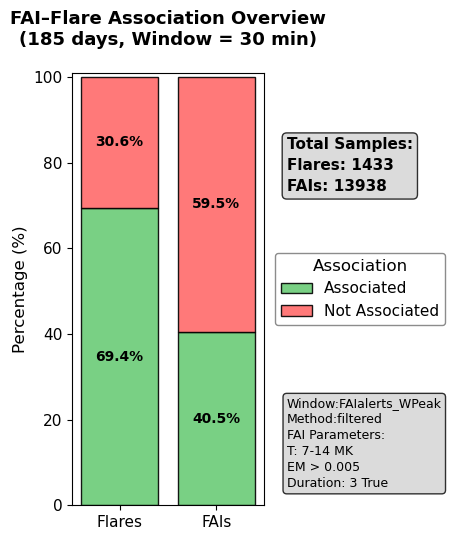

✅ Gráfico guardado en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min/filtered185d_FAI_Flare_DualBar_W30minFAIalerts_WPeak_durTrue_3_T7-14_EM0.005.png

--- Resumen ---
Total Flares: 1433 → 69.4% con FAI, 30.6% sin FAI
Total FAIs: 13938 → 40.5% asociados, 59.5% no asociados


In [14]:
plot_fai_flare_dualbar(
    df_fai_assoc=df_fai_assoc,
    df_anticipation_time=df_anticipation_time,
    n_days=n,
    window_minutes=window_minutes,
    column_assoc="Associated_Flare", 
    fai_column=fai_column)




## flares por ventanas

In [15]:
# plot_fai_flare_triplebar(df_fai_assoc, 
#                          df_anticipation_time, 
#                          n_days=n, 
#                          window_minutes=window_minutes,
#                          column_assoc="Associated_Flare", 
#                          fai_column=fai_column)


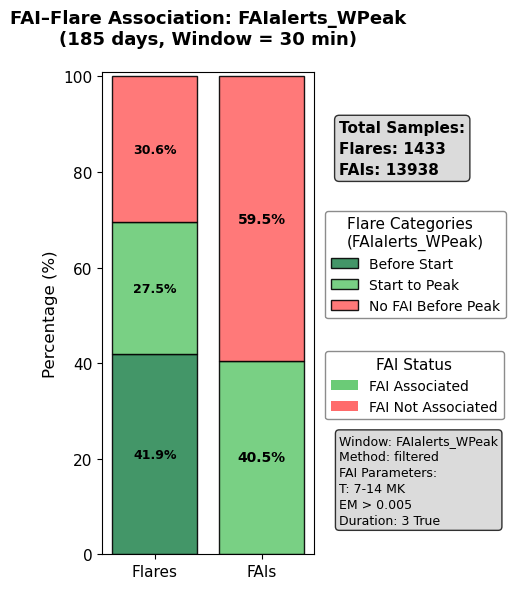

✅ Gráfico guardado en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min/filtered185d_FAI_Flare_TripleBar_FAIalerts_WPeak_W30min_durTrue_3_T7-14_EM0.005.png

--- Resumen para FAIalerts_WPeak ---
FLARES (Total: 1433):
  • Before Start: 601 (41.9%)
  • Start to Peak: 394 (27.5%)
  • No FAI Before Peak: 438 (30.6%)
FAIs (Total: 13938):
  • Asociados a flares:    5645 (40.5%)
  • No asociados a flares: 8293 (59.5%)


In [16]:
plot_fai_flare_triplebar2(df_fai_assoc, 
                         df_anticipation_time, 
                         n_days=n, 
                         window_minutes=window_minutes,
                         column_assoc="Associated_Flare", 
                         fai_column=fai_column)
